In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from netCDF4 import Dataset
import multiprocessing
from numba import jit
import scipy
from histogram import histogram, percentile_from_histogram, value_from_histogram

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

# Towards an automatic way to tune free parameters

Of the many components that go into generating supplemental locations, one that has the potential to make the strongest impact on the performance of QMD/resulting biases is the choice of free parameters -- namely, the coefficients used to scale the penalty function components. 

In previous iterations of the code, these coefficients appear to have been selected somewhat arbitrarily, with terrain being weighed the largest and thus differences in terrain heights between the origin point and a potential SL would deem that SL imcompatible. But is this physically correct? And/or does this result in smaller biases?

This is where my analysis comes in -- what should the coefficients be set to in order to get the best forecast outcome? In other words, which model component (terrain, climo) is most important in quantifying the similarity between points?

Previously, I did this a bit slap dash (manually changing the coefficient values over a couple of model runs) but that feels inefficient and deeply unscientific. So here I'm attempting to do something a bit more sophisticated. 

To do this "automatic" analysis (which I'll describe below), we first need to tackle the elephant in the room: the blend CONUS grid is much much too large to run with over and over again -- the supplemental locations code takes about 1 hour to run on CONUS with ~30 nodes...so very expensive. 

So here, we now have a relatively small but still representative sample of points spanning all of (land) CONUS, totaling 500 points. These points are run through a simplified version of the supplemental locations code which takes about 3.5 minutes to run. That way, we can test many different combinations of coefficients. 

Which brings me to the main goal: in lieu of trying to manually cover all of parameter space the coefficients can occupy, we can instead train a model to learn the correlation between QMD performance (bias) and the combination of penalty function coefficients. We can then use the model to explore parameter space much more efficiently than if we just stuck to running the supplemental locations code over and over again. 

## Building Intuition

In [604]:
ls = 1.

periodic_kernel = ExpSineSquared(length_scale=ls, length_scale_bounds=(0.1, 10.0),periodicity=3,
    periodicity_bounds=(1.0, 10.0))
p10 = ExpSineSquared(length_scale=ls, periodicity=0.5,length_scale_bounds=(1e-1, 10.0))
rbf_kernel = RBF(length_scale=ls,length_scale_bounds=(1e-1, 10.0))
combined_kernel = (periodic_kernel + rbf_kernel)
m_kernel = Matern(length_scale=ls, nu=2.5,length_scale_bounds=(1e-1, 10.0))

In [599]:
X = np.linspace(0, 5, 100).reshape(-1,1)

In [600]:
X_train = np.random.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.sin((X_train[:, 0] - 2.5) ** 2)
n_samples = 5

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


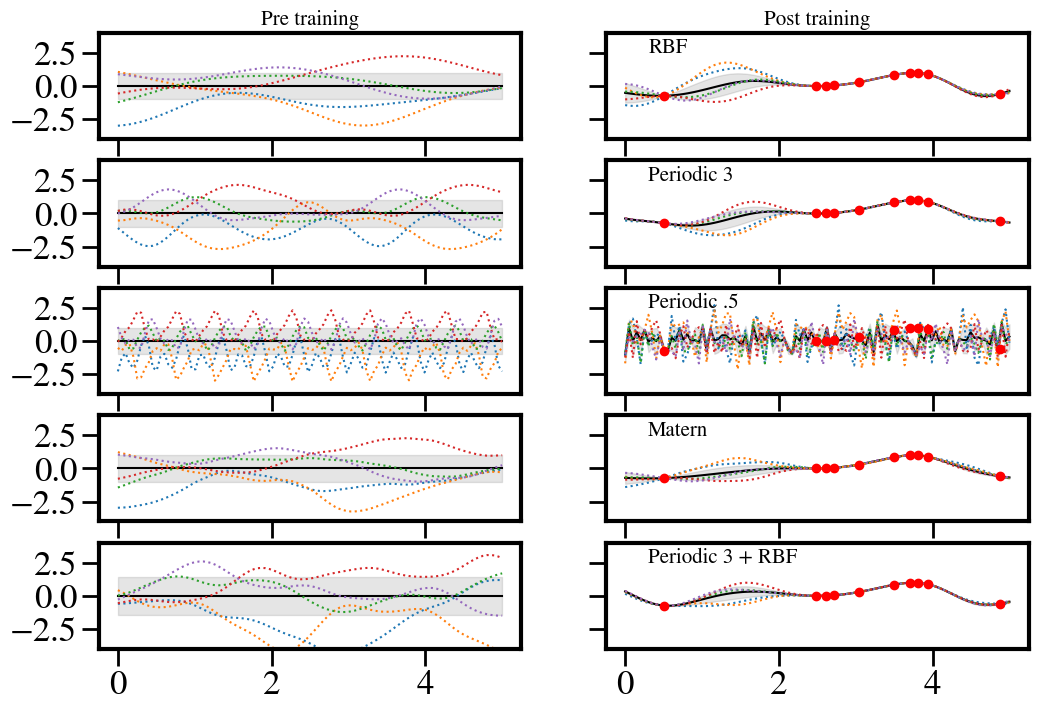

In [608]:


k_choices = [rbf_kernel, periodic_kernel, p10, m_kernel, combined_kernel]
k_names = ['RBF', 'Periodic 3','Periodic .5', 'Matern', 'Periodic 3 + RBF']

fig, axes = plt.subplots(len(k_choices), 2, sharex=True, sharey=True, figsize=(12, 8))

axes[0,0].set_ylim([-4,4])
axes[0,0].set_title('Pre training', fontsize=15)
axes[0,1].set_title('Post training', fontsize=15)

for k in range(len(k_choices)):
    gp = GaussianProcessRegressor(kernel=k_choices[k])

    axes[k,1].annotate(f'{k_names[k]}', xy=(0.3, 2.5), fontsize=15)

    y_mean, y_std = gp.predict(X, return_std=True)
    y_samples = gp.sample_y(X, 5)
    axes[k,0].fill_between(
        np.ravel(X),
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    axes[k,0].plot(np.ravel(X), y_mean, color="black", label="Mean")
    for s in range(5):
        if (s == 1) and (k==0):
            axes[k, 0].plot(X,y_samples[:,s] , ls=':', label='Before training')
        else:
            axes[k, 0].plot(X,y_samples[:,s] , ls=':')

    gp.fit(X_train, y_train)
    y_mean, y_std = gp.predict(X, return_std=True)
    y_samples = gp.sample_y(X, 5)
    axes[k,1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
    axes[k,1].fill_between(
        np.ravel(X),
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
    )
    axes[k,1].plot(np.ravel(X), y_mean, color="black", label="Mean")
    for s in range(5):
        if (s == 1) and (k==0):
            axes[k, 1].plot(X,y_samples[:,s] , ls=':', label='After training')
        else:
            axes[k, 1].plot(X,y_samples[:,s] , ls=':')


#axes[0,0].legend()
#axes[0,1].legend()

In [563]:
np.shape(y_samples)

(100, 5)

## Step 1: developing a training set

As noted above, our training set will consist of the actual output from the supplemental locations --> bias analysis on the pared down CONUS grid. Given our parameter space (3 coefficients -- I'm fixing distance to 0.001 -- that can range from 0-1), if we have the input (coefficients) and their output (bias) from ~50 iterations, that should be enough for a model like Gaussian Processes to get the sense of how the coefficients impact the bias. 

So for each month, I've run 50 iterations of the supplemental locations code, each with different coefficients as defined by:

In [700]:
coeffs = np.genfromtxt("/scratch2/STI/mdl-sti/Sidney.Lower/blend-qmd-dev/supplemental_locations/sidney_files/optimizing_coeffs/coefficient_combinations.txt")

#
# Generated from generate_coefficients.py
#

In [5]:
coeffs[:10]

array([[0.0223, 0.8678, 0.013 ],
       [0.0782, 0.0027, 0.3812],
       [0.0233, 0.026 , 0.0146],
       [0.854 , 0.0052, 0.0308],
       [0.0013, 0.0075, 0.0054],
       [0.0035, 0.6511, 0.0016],
       [0.1039, 0.0861, 0.0015],
       [0.0489, 0.1923, 0.009 ],
       [0.0274, 0.1878, 0.7086],
       [0.0027, 0.048 , 0.0102]])

Together with their associated average monthly biases, we have a complete training set. Next thing we need is a model to learn the correlation between input and output.

### exploring trends in data

In [840]:
#bias_files = sorted(glob('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/testing_weight_combos/v*/7/bias_with_sl_CONUS_expanded.zarr/'))

month = 7
bias_files = []
for i in range(1,101):
    bf = f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/testing_weight_combos/v{i}/{month}/bias_with_sl_CONUS_expanded.zarr/'
    temp = glob(bf)
    if len(temp) == 0:
        continue
    else:
        bias_files.append(bf)
bias = xr.open_mfdataset(bias_files, combine='nested', concat_dim=[pd.Index(np.arange(1,len(bias_files)+1), name="model_version")],
                         engine='zarr')
nmods = len(bias_files)

In [868]:
output_bias = np.abs(bias.bias.mean(dim='day').mean(dim='grid_point').mean(dim='member').data.compute())
nmods = len(bias_files)

In [814]:
normed_coeffs = np.zeros((nmods,3))
for i in range(nmods):
    normed_coeffs[i] = coeffs[i] / coeffs[i][0] 

In [810]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Text(0.5, 0, '$\\log(\\mathrm{Terrain/Climo})$')

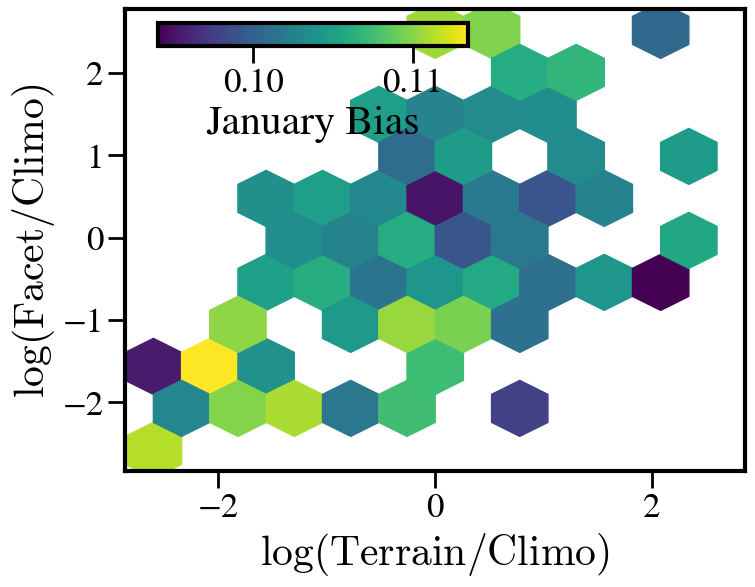

In [869]:
fig, ax = plt.subplots(1,1)

cs = ax.hexbin(np.log10(normed_coeffs[:,1]), np.log10(normed_coeffs[:,2]), output_bias, gridsize=10)
normalize = matplotlib.colors.Normalize(vmin=np.min(output_bias),vmax=np.max(output_bias))
mapper = matplotlib.cm.ScalarMappable(norm=normalize, cmap='viridis')
cbar_ax = inset_axes(ax,width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.03, 0, 1, 1),bbox_transform=ax.transAxes)
cbar = plt.colorbar(mapper,label='January Bias', cax=cbar_ax, orientation='horizontal')
#cbar.ax.set_xticks([-0.054, -0.05, -0.046])
#cbar.ax.set_xticklabels(['-0.06', '-0.05', '-0.04'])
ax.set_ylabel('$\log(\mathrm{Facet/Climo})$')
ax.set_xlabel('$\log(\mathrm{Terrain/Climo})$')

## Step 2: Developing a GP model

In [84]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, ConstantKernel, Matern
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

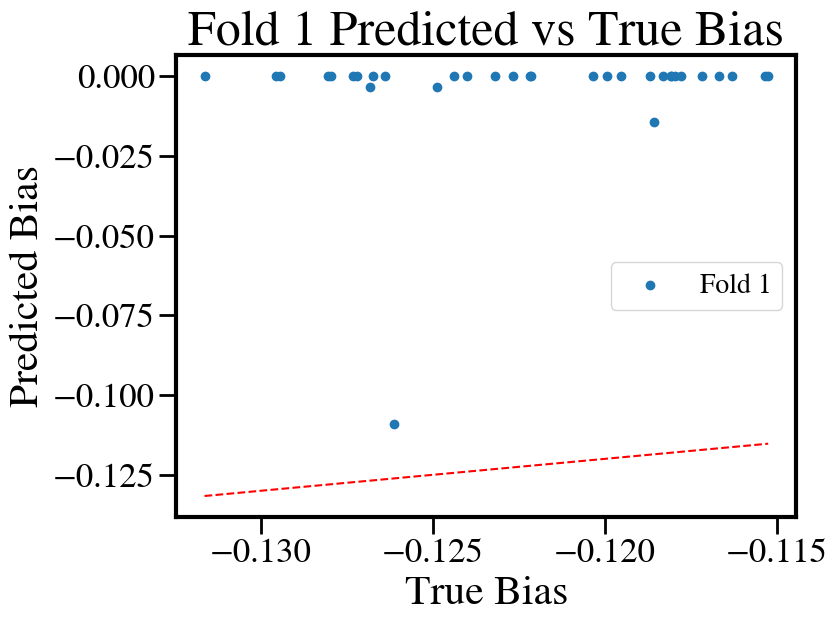

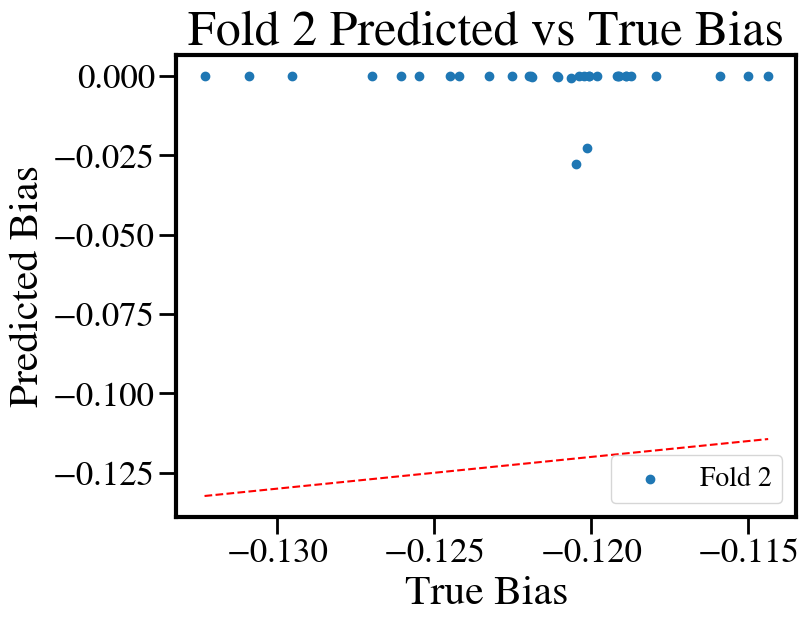

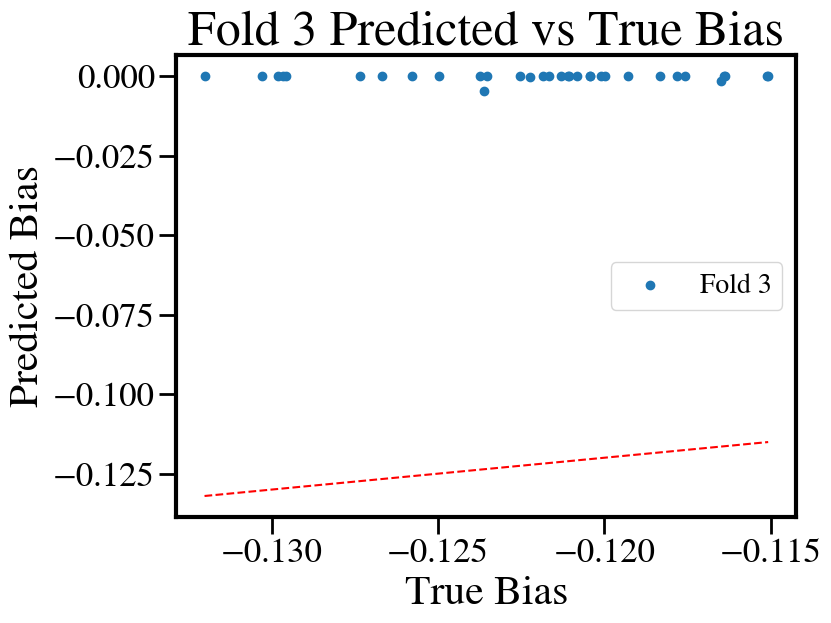

In [616]:
from sklearn.model_selection import KFold

# Set up 5-fold cross-validation
kf = KFold(n_splits=3)
fold = 1

for train_index, test_index in kf.split(normed_coeffs[:,1:]):
    X_cv_train, X_cv_test = normed_coeffs[:,1:][train_index], normed_coeffs[:,1:][test_index]
    y_cv_train, y_cv_test = Y_train_scaled[train_index], Y_train_scaled[test_index]
    
    # Train on this fold
    gp.fit(X_cv_train, y_cv_train)
    
    # Predict on the test set
    y_pred = gp.predict(X_cv_test)
    
    # Plot actual vs. predicted values
    plt.figure()
    plt.scatter(y_cv_test, y_pred, label=f'Fold {fold}')
    plt.plot([min(y_cv_test), max(y_cv_test)], [min(y_cv_test), max(y_cv_test)], 'r--')  # y=x line
    plt.xlabel('True Bias')
    plt.ylabel('Predicted Bias')
    plt.title(f'Fold {fold} Predicted vs True Bias')
    plt.legend()
    plt.show()
    
    fold += 1

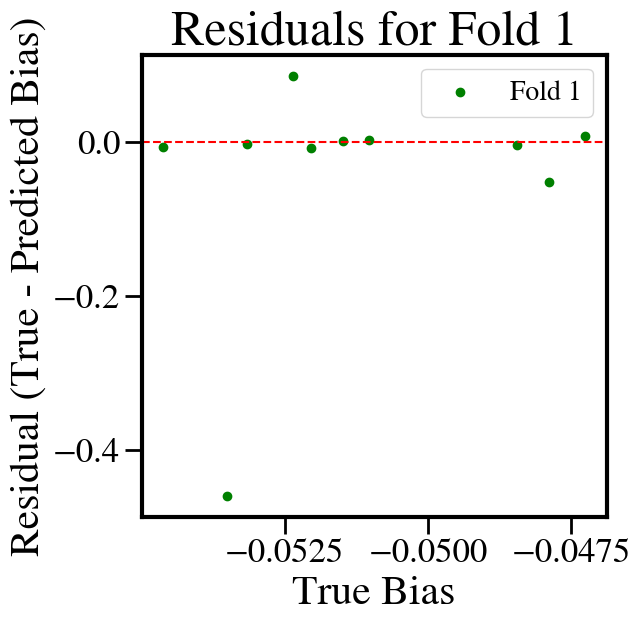

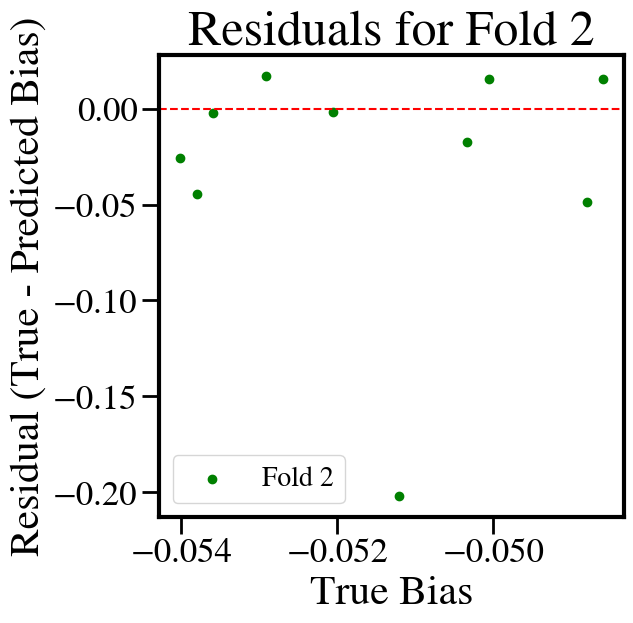

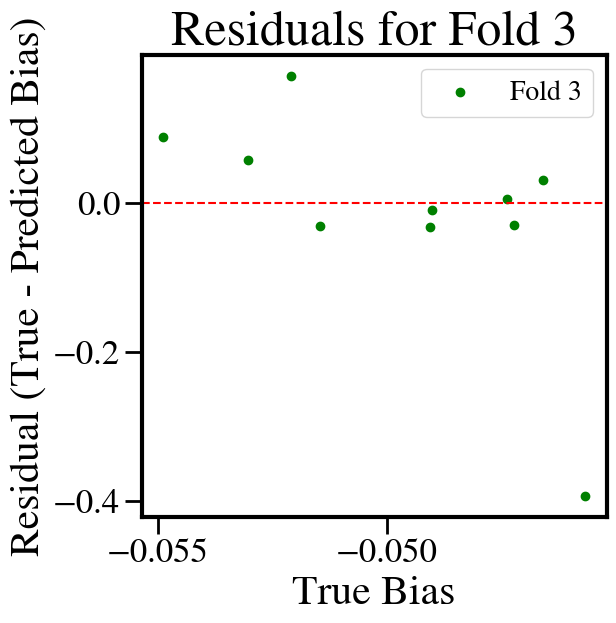

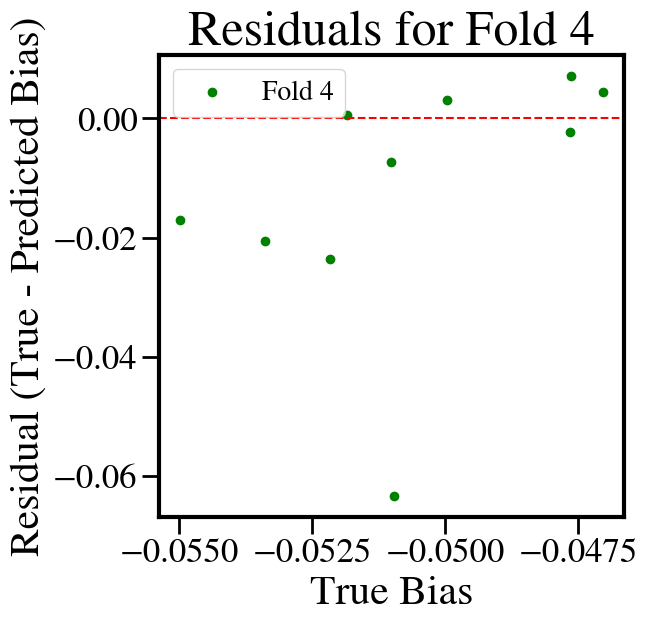

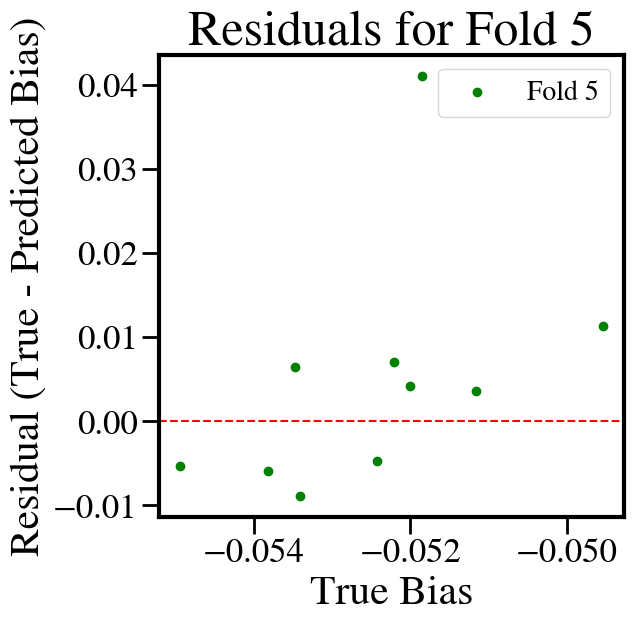

In [328]:
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled), 1):
    gp.fit(X_train_scaled[train_idx], mb[train_idx])
    y_pred = gp.predict(X_train_scaled[test_idx])
    residuals = mb[test_idx] - y_pred
    
    plt.figure(figsize=(6, 6))
    plt.scatter(mb[test_idx], residuals, label=f'Fold {fold}', color='green')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Bias")
    plt.ylabel("Residual (True - Predicted Bias)")
    plt.title(f'Residuals for Fold {fold}')
    plt.legend()
    plt.show()

## Step 3: iterate with Bayesian optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Real

In [862]:
ls = .005

periodic_kernel = ExpSineSquared(length_scale=ls, periodicity=1)
rbf_kernel = RBF(length_scale=ls)
combined_kernel = ConstantKernel(ls) * (periodic_kernel + rbf_kernel)
m_kernel = ConstantKernel(ls) * Matern(length_scale=ls, nu=2.5)

pk = ExpSineSquared(length_scale=.1, length_scale_bounds=(0.0001, 10.0),periodicity=0.6,
    periodicity_bounds=(0.05, 10.0))

gp = GaussianProcessRegressor(kernel=periodic_kernel, alpha=1e-7)

In [870]:
normed_coeffs = np.zeros((nmods,3))
for i in range(nmods):
    normed_coeffs[i] = coeffs[i] / coeffs[i][0] 

Y_train  = np.abs(output_bias)

In [871]:
Y_train_scaled = scaler.fit_transform(Y_train.reshape(-1, 1)).ravel()

In [845]:
t2g = np.log10(np.sort(normed_coeffs[:,1]).reshape(-1,1))
f2g = np.log10(np.sort(normed_coeffs[:,2]).reshape(-1,1))

Text(0, 0.5, 'GP Model Value')

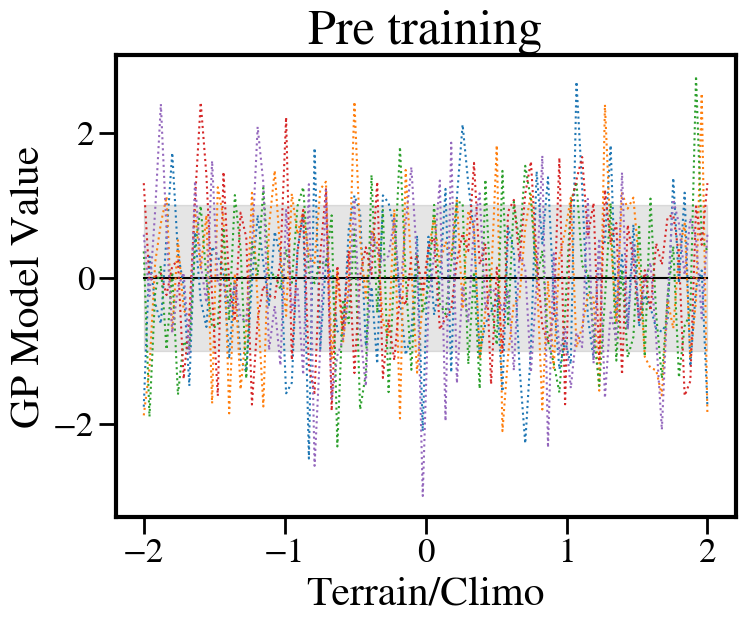

In [860]:
xx = np.linspace(-2, 2, 100).reshape(-1,1)

y_mean, y_std = gp.predict(xx, return_std=True)
y_samples = gp.sample_y(xx, 5)
plt.fill_between(
    np.ravel(xx),
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
plt.plot(np.ravel(xx), y_mean, color="black", label="Mean")
plt.plot(xx,y_samples , ls=':', label='Before training')
plt.title('Pre training')
plt.xlabel('Terrain/Climo')
plt.ylabel('GP Model Value')

In [872]:
X_train, X_test, y_train, y_test = train_test_split(t2g, Y_train_scaled, test_size=0.2)
gp.fit(X_train, y_train)

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1e-07,
                         kernel=ExpSineSquared(length_scale=0.005, periodicity=1))

Text(0, 0.5, 'Bias (scaled)')

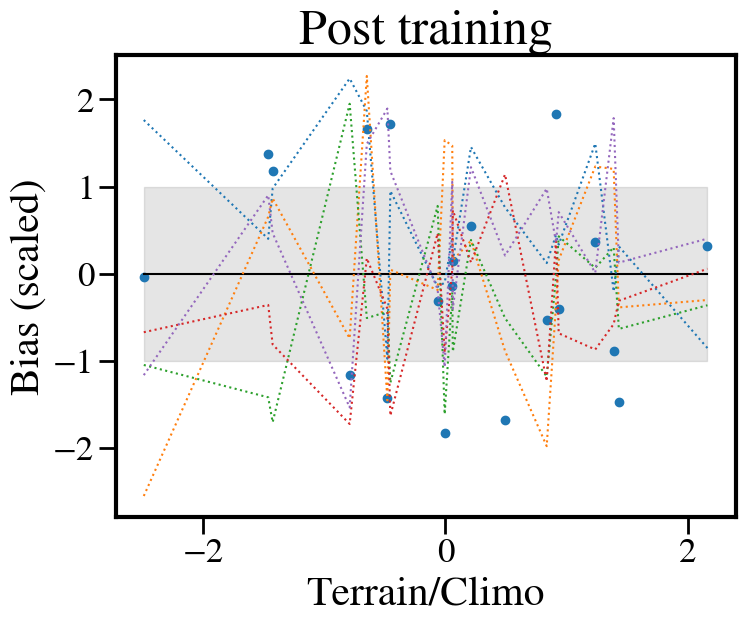

In [873]:
xtest_sorted = np.sort(np.ravel(X_test)).reshape(-1, 1)
y_mean, y_std = gp.predict(xtest_sorted, return_std=True)
y_samples = gp.sample_y(xtest_sorted, 5)
plt.fill_between(
    np.ravel(xtest_sorted),
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
plt.plot(np.ravel(xtest_sorted), y_mean, color="black", label="Mean")
plt.plot(xtest_sorted,y_samples , ls=':', label='Before training')
plt.scatter(X_test, y_test)
plt.title('Post training')
plt.xlabel('Terrain/Climo')
plt.ylabel('Bias (scaled)')

In [863]:
X_train, X_test, y_train, y_test = train_test_split(normed_coeffs[:,1:], Y_train_scaled, test_size=0.2)
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-07,
                         kernel=ExpSineSquared(length_scale=0.005, periodicity=1))

In [864]:
y_pred = gp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

scores = cross_val_score(gp, normed_coeffs[:,1:], Y_train_scaled, cv=5,scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()}")

Mean Squared Error: 0.8825642856885212
Cross-Validation MSE: nan


/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-pa

In [432]:
# Define the parameter space
space = [
    Real(0, 100, name='terrain-to-gamma'),
    Real(0, 100, name='facets-to-gamma')
]


# Define the objective function
def objective_function(weights):
    # Unpack weights
    t2g, f2g = weights

    # Evaluate the penalty function using the surrogate model
    penalty_value = gp.predict([[t2g, f2g]])[0]
    return np.float32(penalty_value)

# Run Bayesian Optimization
res = gp_minimize(objective_function, space, n_calls=50)

# Get the best result
best_weights = res.x
print("Optimal Weights:", best_weights)

Optimal Weights: [40.895910865860316, 95.63105173128945]


# Oops maybe not GP

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
coeffs = np.genfromtxt("/scratch2/STI/mdl-sti/Sidney.Lower/blend-qmd-dev/supplemental_locations/sidney_files/optimizing_coeffs/coefficient_combinations.txt")


In [4]:
bias_files = sorted(glob('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/testing_weight_combos/v*/7/bias_with_sl_CONUS_expanded.zarr/'))

bias = xr.open_mfdataset(bias_files, combine='nested', concat_dim=[pd.Index(np.arange(1,len(bias_files)+1), name="model_version")],
                         engine='zarr')

In [5]:
output_bias = bias.bias.mean(dim='day').mean(dim='grid_point').data.compute()
mb = output_bias[:,10]

In [35]:
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(coeffs[:99])

Y_train_scaled = scaler.fit_transform(mb.reshape(-1, 1)).ravel()

X_train_scaled = coeffs[:99]
#Y_train_scaled

In [36]:
# X -> input features, y -> target variable (bias data, etc.)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, Y_train_scaled, test_size=0.2, random_state=42)

In [37]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [38]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.28796097013496


In [39]:
scores = cross_val_score(rf, coeffs[:99], mb, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {np.log10(-scores.mean())}")

Cross-Validation MSE: -4.276513087599958


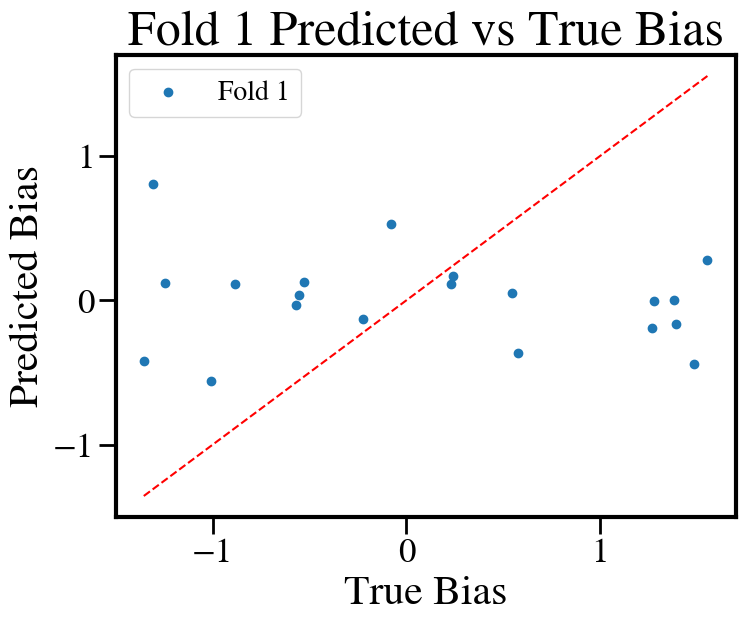

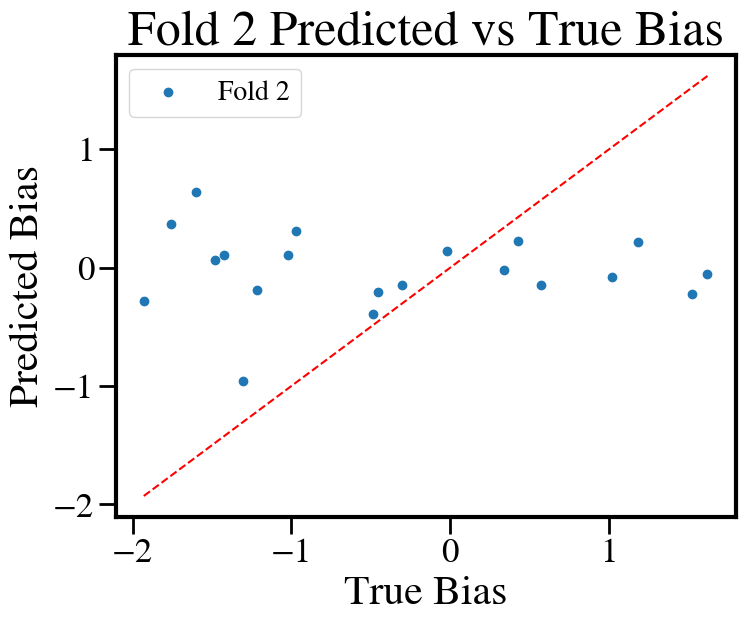

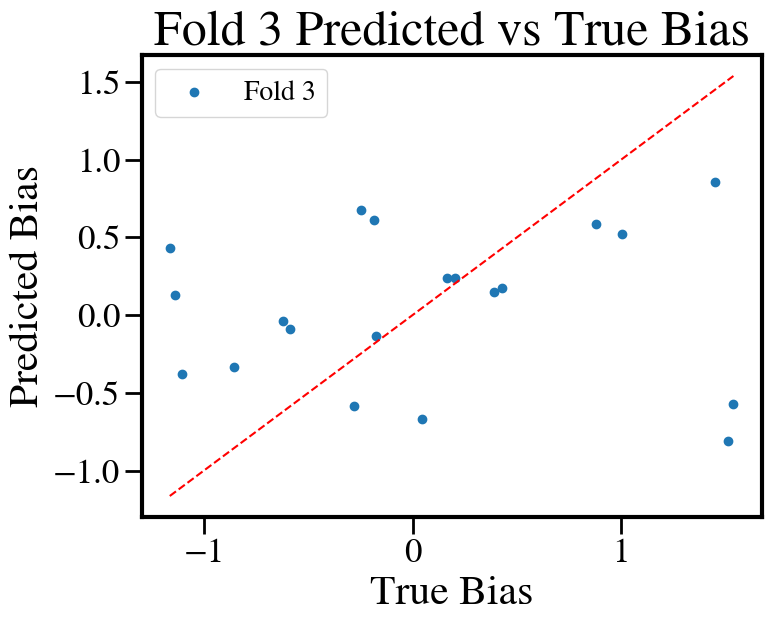

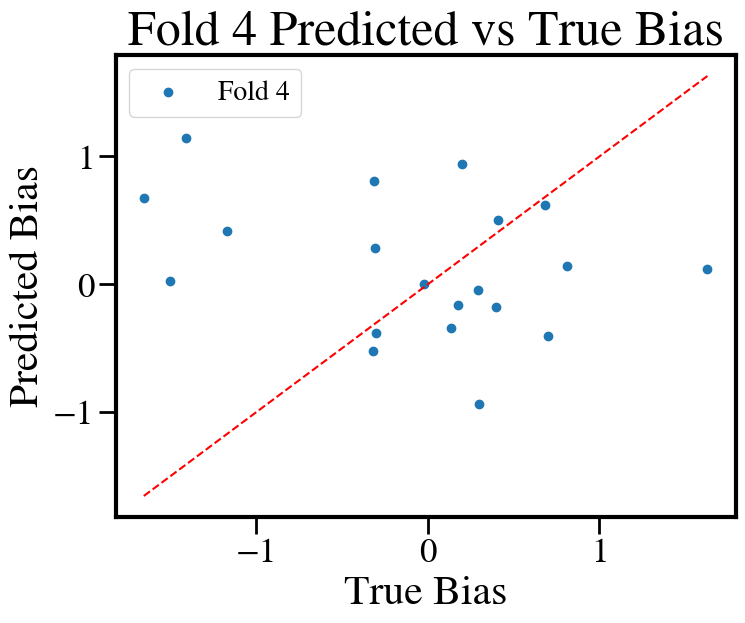

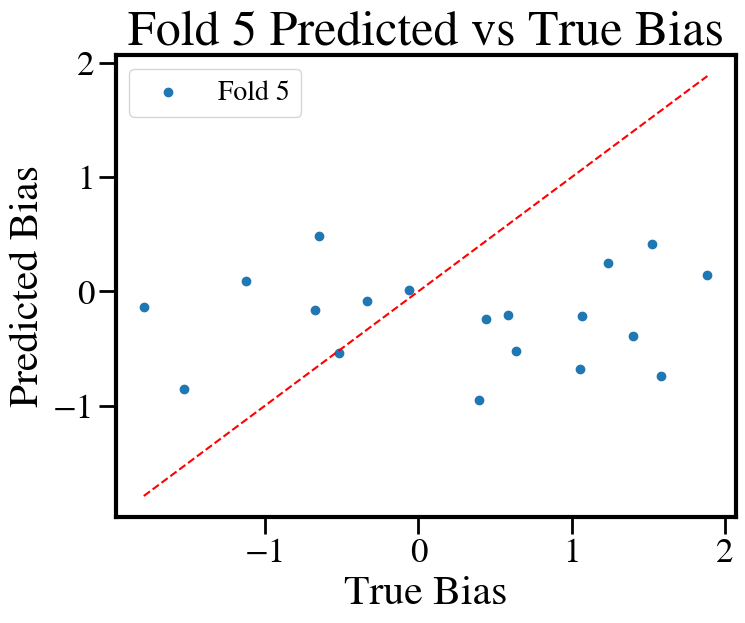

In [28]:
from sklearn.model_selection import KFold

# Set up 5-fold cross-validation
kf = KFold(n_splits=5)
fold = 1

for train_index, test_index in kf.split(X_train_scaled):
    X_cv_train, X_cv_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_cv_train, y_cv_test = Y_train_scaled[train_index], Y_train_scaled[test_index]
    
    # Train on this fold
    rf.fit(X_cv_train, y_cv_train)
    
    # Predict on the test set
    y_pred = rf.predict(X_cv_test)
    
    # Plot actual vs. predicted values
    plt.figure()
    plt.scatter(y_cv_test, y_pred, label=f'Fold {fold}')
    plt.plot([min(y_cv_test), max(y_cv_test)], [min(y_cv_test), max(y_cv_test)], 'r--')  # y=x line
    plt.xlabel('True Bias')
    plt.ylabel('Predicted Bias')
    plt.title(f'Fold {fold} Predicted vs True Bias')
    plt.legend()
    plt.show()
    
    fold += 1

In [29]:
importances = rf.feature_importances_
print(importances)

[0.28126887 0.42138178 0.29734935]


In [140]:
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42,min_samples_split=12)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=12, n_estimators=200, random_state=42)

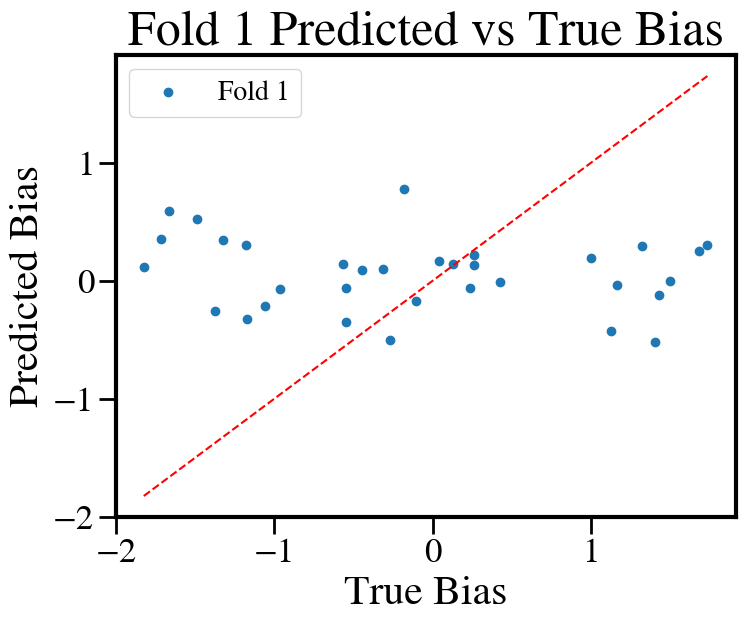

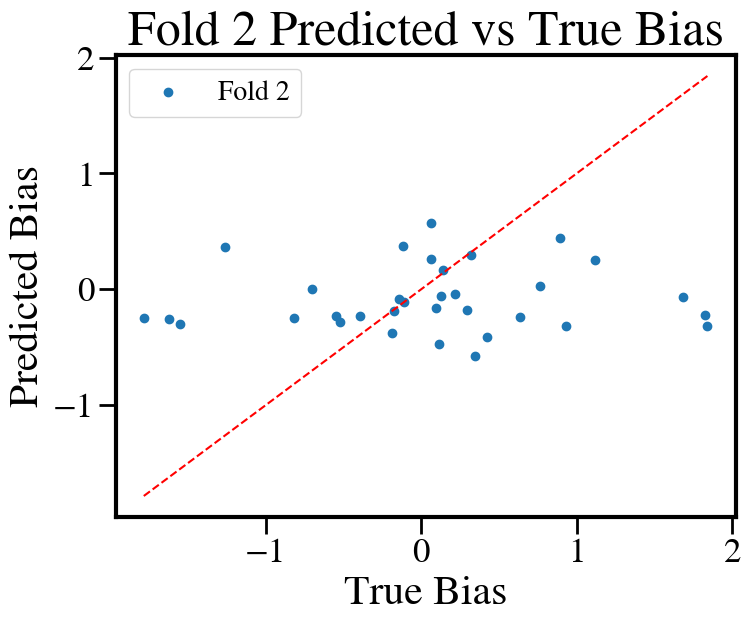

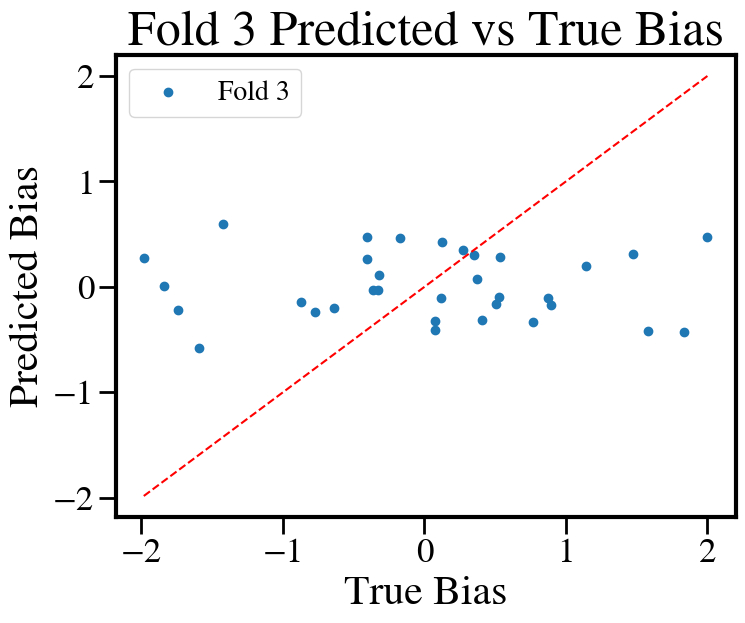

In [141]:
from sklearn.model_selection import KFold

# Set up 5-fold cross-validation
kf = KFold(n_splits=3)
fold = 1

for train_index, test_index in kf.split(X_train_scaled):
    X_cv_train, X_cv_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_cv_train, y_cv_test = Y_train_scaled[train_index], Y_train_scaled[test_index]
    
    # Train on this fold
    rf.fit(X_cv_train, y_cv_train)
    
    # Predict on the test set
    y_pred = rf.predict(X_cv_test)
    
    # Plot actual vs. predicted values
    plt.figure()
    plt.scatter(y_cv_test, y_pred, label=f'Fold {fold}')
    plt.plot([min(y_cv_test), max(y_cv_test)], [min(y_cv_test), max(y_cv_test)], 'r--')  # y=x line
    plt.xlabel('True Bias')
    plt.ylabel('Predicted Bias')
    plt.title(f'Fold {fold} Predicted vs True Bias')
    plt.legend()
    plt.show()
    
    fold += 1

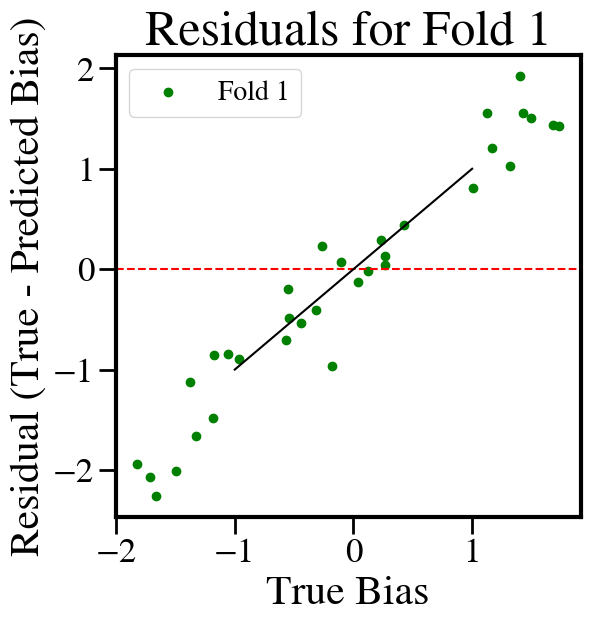

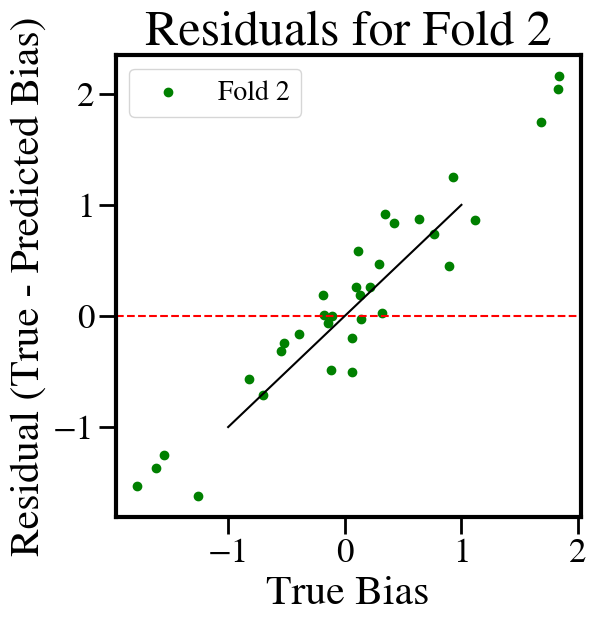

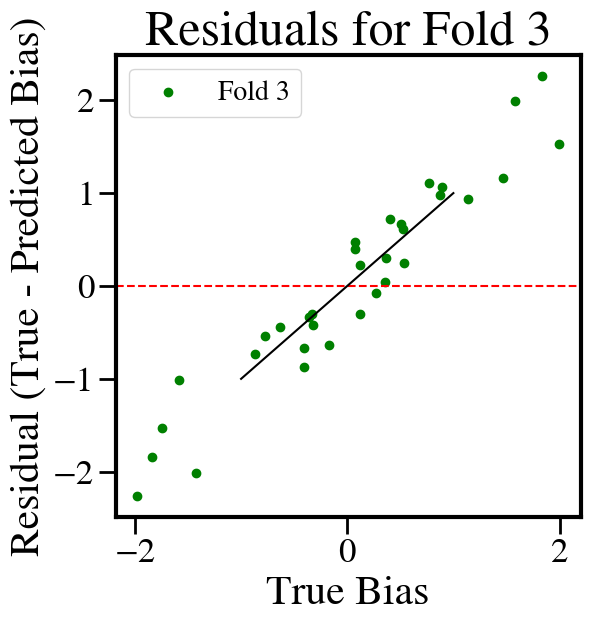

In [142]:
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled), 1):
    rf.fit(X_train_scaled[train_idx], Y_train_scaled[train_idx])
    y_pred = rf.predict(X_train_scaled[test_idx])
    residuals = Y_train_scaled[test_idx] - y_pred
    
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_train_scaled[test_idx], residuals, label=f'Fold {fold}', color='green')
    plt.axhline(0, color='red', linestyle='--')
    plt.plot([-1,1], [-1,1], color='black')
    plt.xlabel("True Bias")
    plt.ylabel("Residual (True - Predicted Bias)")
    plt.title(f'Residuals for Fold {fold}')
    plt.legend()
    plt.show()

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 12, 13]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, Y_train_scaled)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 12, 13],
                         'n_estimators': [100, 200, 300, 500, 700]},
             scoring='neg_mean_squared_error')

In [139]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 12, 'n_estimators': 200}


# Results from GP: are biases lower with these optimal coefficients?

In [197]:
c_v1 = [0.592, 0.844, 0.856]
c_v2 = [0.797, 0.183, 0.78]

months = [1,4,7,11]

In [180]:
no_sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_without_sl_CONUS_expanded.zarr')
default = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_with_sl_CONUS_expanded.zarr')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [238]:
v1 = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/testing_weight_combos/optimal_weights_v1/7/bias_with_sl_CONUS_expanded.zarr/',
                    engine='zarr')
v2 = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/testing_weight_combos/optimal_weights_v2/7/bias_with_sl_CONUS_expanded.zarr/',
                    engine='zarr')
v3 = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/testing_weight_combos/optimal_weights_v3/11/bias_with_sl_CONUS_expanded.zarr/',
                    engine='zarr')

In [233]:
no_sl_b = no_sl.bias.mean(dim='day').mean(dim='locations').data
default_b = np.mean(default.bias.mean(dim='day').data[:,:,::50], axis=2)
v1_b = v1.bias.mean(dim='day').mean(dim='member').data
v2_b = v2.bias.mean(dim='day').mean(dim='member').data
v3_b = v3.bias.mean(dim='day').mean(dim='member').data

In [229]:
c_v1 = [0.5928446182250184, 0.8442657485810175, 0.857945617622757]
c_v2 = [0.7965429868602331, 0.18343478986616382, 0.7796910002727695]
c_v2 = [0.3, 0.18343478986616382, 0.7796910002727695]

Mean bias for = 0.15090954176647978
Mean bias for = 0.04796984431306168
Mean bias for = -0.1040943590135209


(-1.0, 1.0)

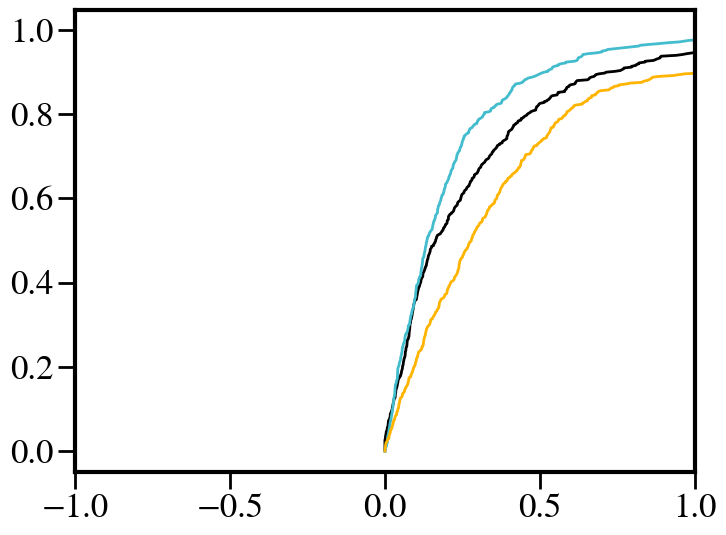

In [240]:
hrange = (-6, 6)
nbins=30

coolors = ['black', '#43BCCD', '#FFB400', '#7FB800', '#DC136C']

#plt.hist(no_sl_b[2], range=hrange, bins=nbins, color='black', alpha=0.4)
#plt.hist(default_b[2], range=hrange, bins=nbins, histtype='step', color='#43BCCD')

for i,model in enumerate([no_sl_b, default_b, v3_b]):

    if i in [0,1]:
        print(f'Mean bias for = {np.mean(model[-1])}')
        b_sorted = np.sort(np.abs(model[-1]))
    else:
        print(f'Mean bias for = {np.mean(model)}')
        b_sorted = np.sort(np.abs(model))
    n = len(b_sorted)
    y = np.arange(n)/n
    plt.plot(b_sorted, y, color=coolors[i], lw=2)

plt.xlim([-1,1])

In [205]:
dat = no_sl.bias.mean(dim='day').mean(dim='grid_point').data[:,::50]

In [208]:
no_sl.bias.mean(dim='day').mean(dim='grid_point').data

array([[ 0.00291681,  0.00691744,  0.00341907,  0.00227014, -0.00882738,
         0.01832451,  0.03450431, -0.04275436, -0.06009982, -0.03017032,
         0.00604295, -0.00672256, -0.0194546 , -0.0059309 , -0.00417942,
        -0.02412744,  0.00258611,  0.00536451,  0.00989198,  0.03675309,
        -0.01494861, -0.00378391,  0.00612814,  0.04682519, -0.08774527,
         0.02496511, -0.04717645, -0.06651073,  0.02628896,  0.00683088],
       [-0.05334713, -0.05035347,  0.02993477, -0.08776969, -0.06876058,
        -0.02744303, -0.03862401, -0.08685007, -0.05687432, -0.0335119 ,
        -0.0909358 , -0.0899089 , -0.07454652, -0.01916985, -0.04332366,
        -0.08671757, -0.07247519, -0.01731934, -0.04329798, -0.04089939,
        -0.04344742, -0.07170364, -0.04439368, -0.10053148, -0.060878  ,
        -0.03438951, -0.0416022 , -0.05485334, -0.01069557, -0.06785999],
       [ 0.04929123,  0.12593637,  0.09965179,  0.07342967,  0.08337872,
         0.03689561,  0.07100573,  0.02758508,  0

fuck.